### Wine Classification System (Wine Dataset)

#### Step 1: Data Preparation

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the wine data
wine_df = pd.read_csv('wine_data.csv')

In [13]:
# Initial EDA
print(wine_df.head())

print(wine_df.info())

print(wine_df.describe())

print(wine_df['target'].value_counts(normalize=True))

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

*Initial Data Exploration Notes*

- all features are float data types with no missing values
- the target variable is encoded (0, 1, 2) and also has no missing values
- the target variable is relatively evenly distributed between the 3 values

<Figure size 1500x1000 with 0 Axes>

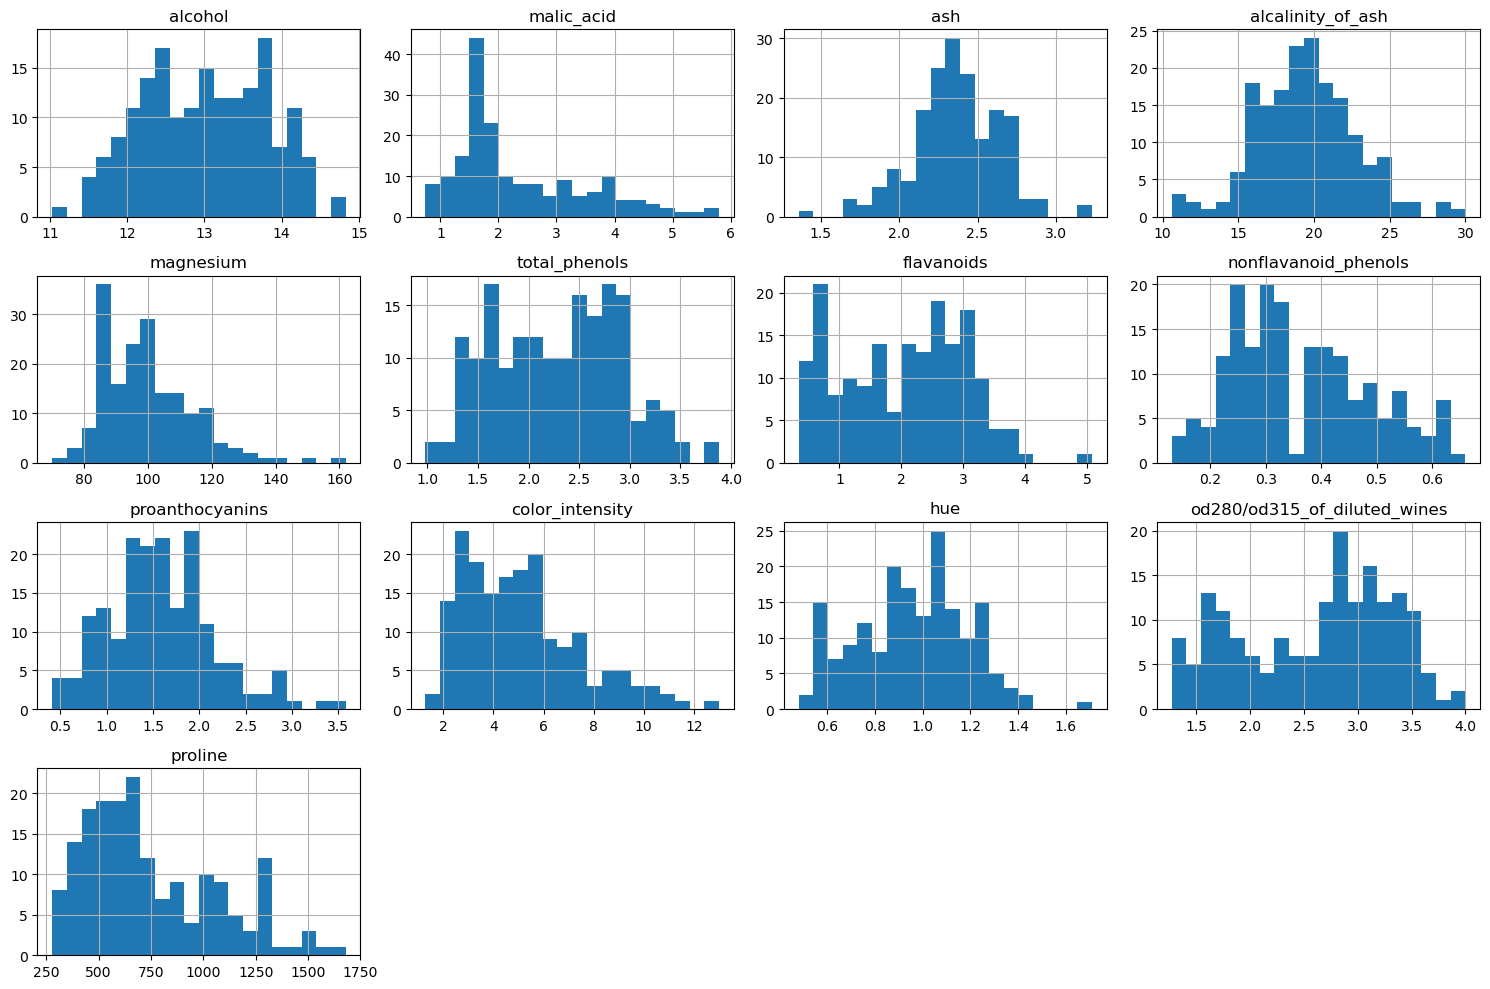

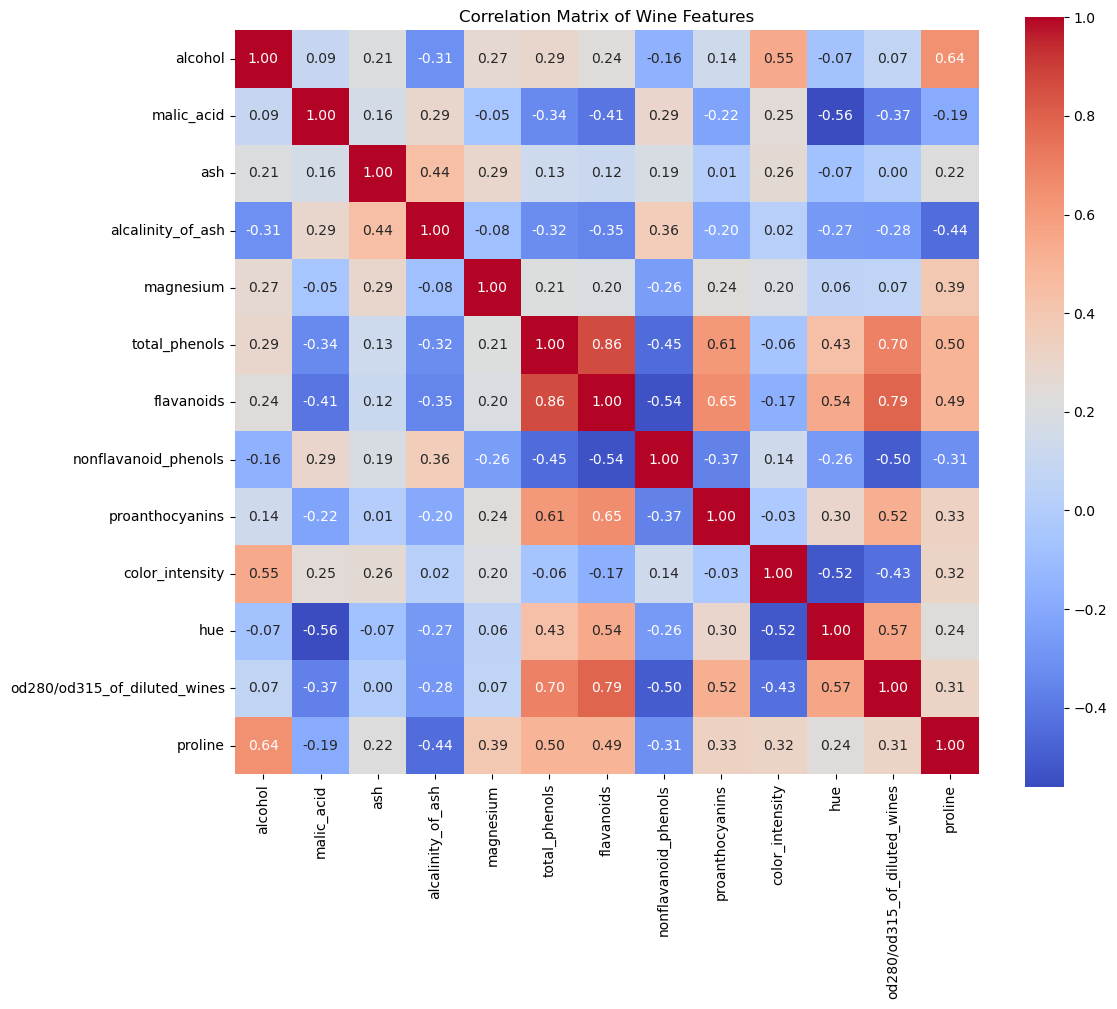

In [15]:
# Exploring feature relationships with feature histograms and a correlation matrix
features = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 
            'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 
            'od280/od315_of_diluted_wines', 'proline']

plt.figure(figsize=(15, 10))
wine_df[features].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

corr_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Wine Features')
plt.show()

*Notes on Data Characteristics*

- measurement scales vary significantly across the features, underscoring the need to standardize
- feature pairs such as total_phenols and flavanoids show strong correlation, suggesting Mahalanobis distance may be the best distance metric

In [18]:
# creating a feature df
X = wine_df.drop('target', axis=1)
y = wine_df['target']

# Splitting the data into training and testing sets (80-20 split, random_state of 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [19]:
# spot checking feature scaling

print("Original first sample:")
print(X_train.iloc[0].values[:5], "...")
print("\nScaled first sample:")
print(X_train_scaled[0][:5], "...")

Original first sample:
[14.34  1.68  2.7  25.   98.  ] ...

Scaled first sample:
[ 1.66529275 -0.60840587  1.21896194  1.60540017 -0.16738426] ...


#### Step 2: Implementing and Optimizing k-Nearest Neighbors

In [22]:
# exploring various distance metrics and evaluating performance with cv scores
metrics = ['euclidean', 'manhattan', 'chebyshev']
k_value = 5

# Dictionary to store results
results = {}

# Loop through list of metrics
for metric in metrics:
        # Create and evaluate model with different metrics and k=5
    knn = KNeighborsClassifier(n_neighbors=k_value, metric=metric)
    # Get cross val scores for model
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    # Store the mean of cv scores as value and metric name as key in results dictionary
    results[metric] = cv_scores.mean()

best_metric = max(results, key=results.get)

print(results)

{'euclidean': 0.9509852216748769, 'manhattan': 0.9785714285714286, 'chebyshev': 0.9229064039408866}


Manhattan distance has the best accuracy score at 0.9786. I'll next explore the Mahalanobis distance.

In [24]:
cov = np.cov(X_train_scaled, rowvar=False)
metric_params = {'V': cov}

# k-NN with Mahalanobis distance and k=5
knn_mahalanobis = KNeighborsClassifier(metric='mahalanobis', metric_params=metric_params)

# cross val to evaluate
cv_scores_mahalanobis = cross_val_score(knn_mahalanobis, X_train_scaled, y_train, cv=5, scoring='accuracy')
results['mahalanobis'] = cv_scores_mahalanobis.mean()

print(results)

{'euclidean': 0.9509852216748769, 'manhattan': 0.9785714285714286, 'chebyshev': 0.9229064039408866, 'mahalanobis': 0.8945812807881774}


Mahalanobis distance showed the lowest accuracy so Manhattan remains the best metric. Moving to hyperparameter tuning using Manhattan.

In [29]:
# defining a parameter grid for grid search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}

# creating the base model
base_model = KNeighborsClassifier(metric='manhattan')

# grid search
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_cv_accuracy = grid_search.best_score_

Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9786


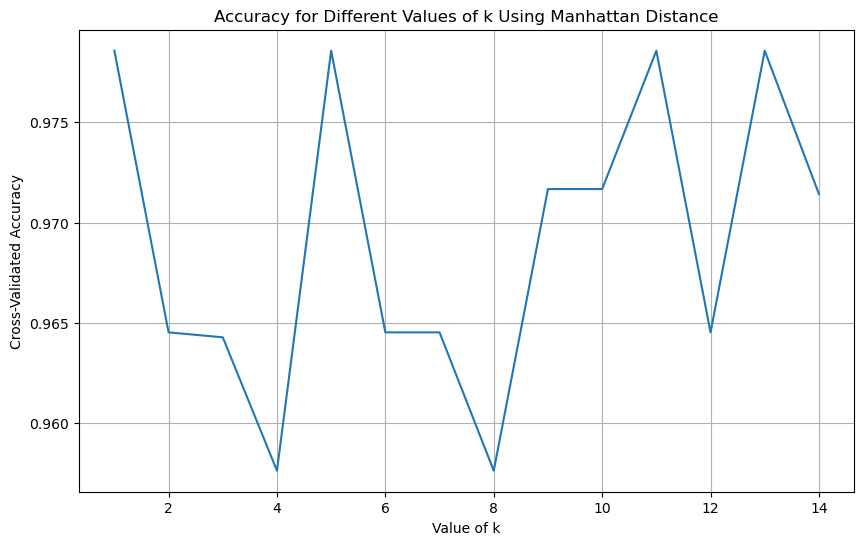

In [30]:
# visualizing accuracy for different k values 

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

k_range = range(1, 15)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validated Accuracy')
plt.title(f'Accuracy for Different Values of k Using Manhattan Distance')
plt.grid(True)
plt.show()

#### Step3: Final Model Fitting and Evaluation

In [ ]:
# fitting the final model
final_model = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')
final_model.fit(X_test_scaled, y_test)

# making predictions on the test set
y_pred = final_model.predict(X_test_scaled)

# calculating accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)

# creating a confusion matrix
cm = confusion_matrix(y_test, y_pred)

Test set accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



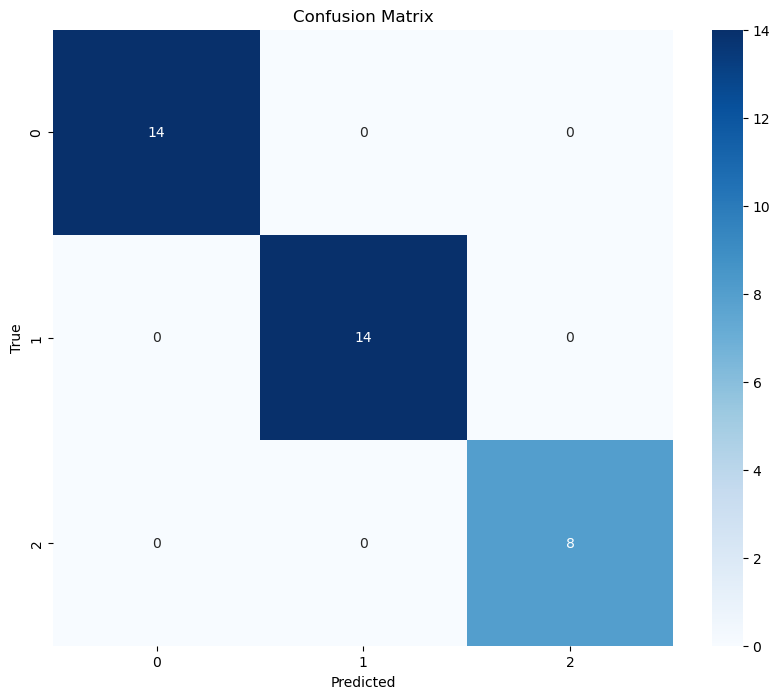

In [32]:
# summary of final model outcomes
print(f"Test set accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Summary of Model Performance and Other Notes

The final version of the k-Nearest Neighbors model for the wine classification system had the following parameters and attributes:

- Distance metric: Manhattan
- Number of neighbors (k): 1
- Neighbor weighting: uniform

The final model performed well in its evaluation: it correctly classified all 36 wines that were in the test dataset. 

More broadly, the model brings us some interesting insights:

- The optimal k value (number of neighbors) of 1 suggests that for wine, similarity to one other type of wine gives a strong indication that the new wine can be classified the same as the reference wine.
- Although multiple pairs of the wine characteristics are correlated, this did not ultimately create complexity in building and optimizing the model.

### Agricultural Feed Recommendation Engine (Chickwts Dataset)

#### Step 1: Data Preparation

In [98]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# Set the random seed for reproducibility
np.random.seed(42)

chickwts_df = pd.read_csv('chickwts_data.csv')

In [99]:
# initial EDA
print("First 5 rows of the dataset:")
print(chickwts_df.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(chickwts_df.isnull().sum())

# Get basic statistics
print("\nBasic statistics:")
print(chickwts_df.describe())

First 5 rows of the dataset:
           feed_name  proteinContent  fatContent  fiberContent  \
0          FirstPeck            19.5         3.2           2.4   
1    ChickStart Plus            18.2         3.8           3.9   
2  EarlyGrow Formula            19.3         4.6           3.2   
3  HatchMate Premier            20.2         3.7           3.8   
4        PeepNourish            19.2         3.9           4.2   

   calciumContent  phosphorusContent  moistureContent  ashContent  \
0            0.82               0.78             10.8         4.5   
1            3.02               0.68              9.3         6.9   
2            1.20               0.69             10.2         5.8   
3            3.16               0.63             11.4         5.7   
4            3.06               0.61              9.3         5.9   

   metabolizableEnergy  lysineContent  methionineContent  particleSize  \
0                 2921           0.96               0.43           3.5   
1          

In [100]:
column_names = chickwts_df.columns

print(column_names)

Index(['feed_name', 'proteinContent', 'fatContent', 'fiberContent',
       'calciumContent', 'phosphorusContent', 'moistureContent', 'ashContent',
       'metabolizableEnergy', 'lysineContent', 'methionineContent',
       'particleSize', 'density', 'price', 'shelfLife', 'weight'],
      dtype='object')


In [102]:
corr_matrix = chickwts_df.corr()

feature_names = ['feed_name', 'proteinContent', 'fatContent', 'fiberContent',
       'calciumContent', 'phosphorusContent', 'moistureContent', 'ashContent',
       'metabolizableEnergy', 'lysineContent', 'methionineContent',
       'particleSize', 'density', 'price', 'shelfLife', 'weight']

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Correlation Matrix of Feed Characteristics')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
scatter_kws = {'alpha': 0.7, 's': 60}
sns.pairplot(chickwts_df, hue='target_name', vars=feature_names, plot_kws=scatter_kws)
plt.suptitle('Scatter Plot Matrix of Feed Characteristics', y=1.02, fontsize=16)
plt.show()


ValueError: could not convert string to float: 'FirstPeck'

### Regional Crime Pattern Analysis (USArrests Dataset)

#### Step 1: Data Preparation

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

arrests_df = pd.read_csv('arrests_data.csv')

In [36]:
# Initial EDA
print(arrests_df.head())

print(arrests_df.info())

print(arrests_df.describe())

#print(wine_df['target'].value_counts(normalize=True))

   Unnamed: 0  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07

*Initial Data Exploration Notes*

- there is no missing data in any of the columns
- column 0 (state) is the only non numeric field
- the numeric data is definitely in different scales and it's not entirely clear what they are (imperative to scale before analyzing)

<Figure size 1200x800 with 0 Axes>

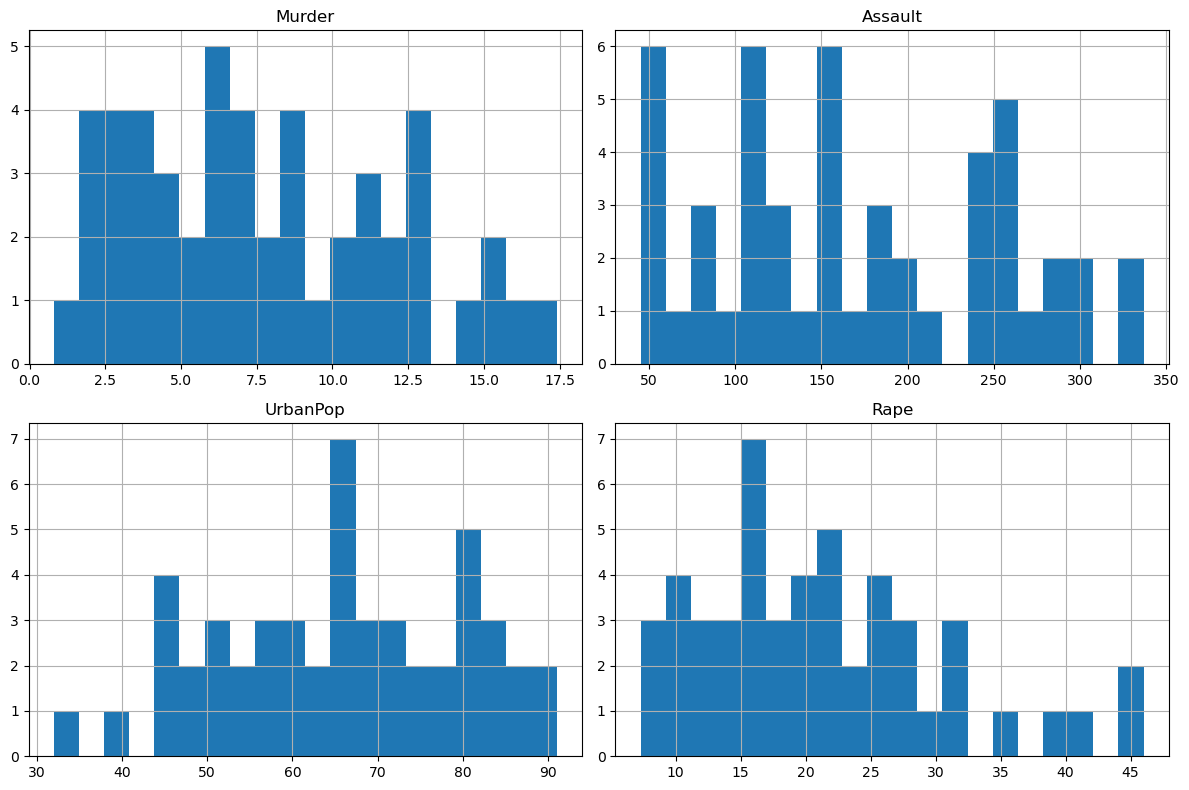

In [56]:
# histograms of raw data
features = ['Murder', 'Assault', 'UrbanPop', 'Rape']

plt.figure(figsize=(12, 8))
X.hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

#### Step 2: Implementing and Optimizing K-Means and GMM

In [71]:
# Select numerical features for clustering - version 1
X1 = df[['Murder', 'Assault', 'UrbanPop', 'Rape']]

# Standardize the data
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

In [72]:
# elbow method to find optimal K for K-Means - version 1
inertia = []
K_range = range(1, 12)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    inertia.append(kmeans.inertia_)

In [73]:
# BIC and AIC to find optimal components for GMM - version 1
bic_scores = []
aic_scores = []
for n in range(1, 15):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X1_scaled)
    bic_scores.append(gmm.bic(X1_scaled))
    aic_scores.append(gmm.aic(X1_scaled))




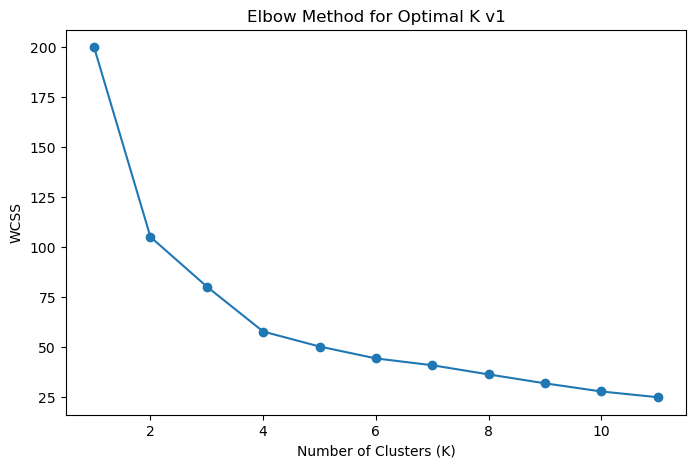

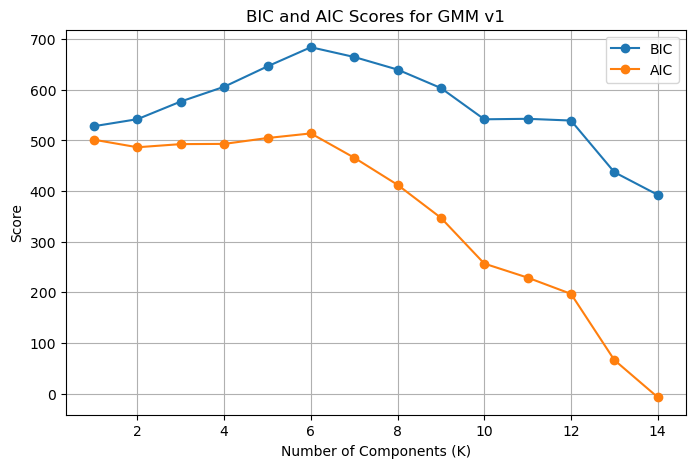

In [74]:
# elbow plot - version 1
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K v1")
plt.show()

# BIC and AIC score plot - version 1
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), bic_scores, marker='o', linestyle='-', label='BIC')
plt.plot(range(1, 15), aic_scores, marker='o', linestyle='-', label='AIC')
plt.xlabel('Number of Components (K)')
plt.ylabel('Score')
plt.legend()
plt.title('BIC and AIC Scores for GMM v1')
plt.grid(True)
plt.show()



*Notes on K and Component Optimization v1*

- the elbow plot has a characteristic shape and shows decreasing improvement after k = 4
- the BIC and AIC curves have an unexpected concavity until K = 6; both show a leveling off at 10
    - Although both show additional improvement after 12, I am choosing 10 to try not to overfit the model

v2 of this exercise drops the Assault data from the analysis, since its histogram is the most uniformly distributed.

In [75]:
# Select numerical features for clustering - version 2
X2 = df[['Murder', 'UrbanPop', 'Rape']]

# Standardize the data
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

In [79]:
# elbow method to find optimal K for K-Means - version 2
inertia2 = []
K_range = range(1, 12)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    inertia2.append(kmeans.inertia_)

In [85]:
# BIC and AIC to find optimal components for GMM - version 2
bic_scores2 = []
aic_scores2 = []
for n in range(1, 15):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X2_scaled)
    bic_scores2.append(gmm.bic(X2_scaled))
    aic_scores2.append(gmm.aic(X2_scaled))




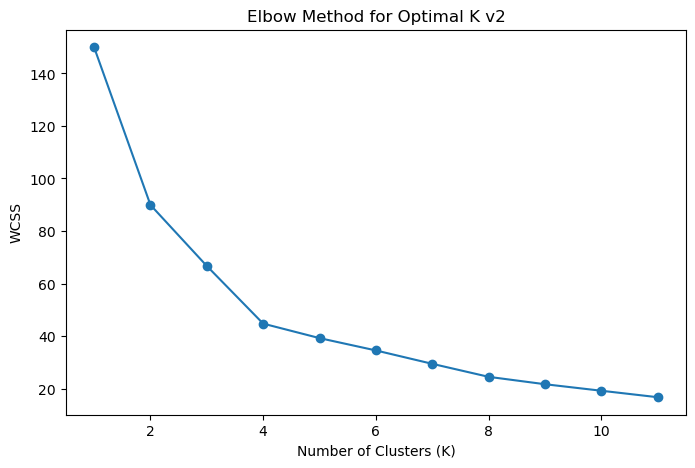

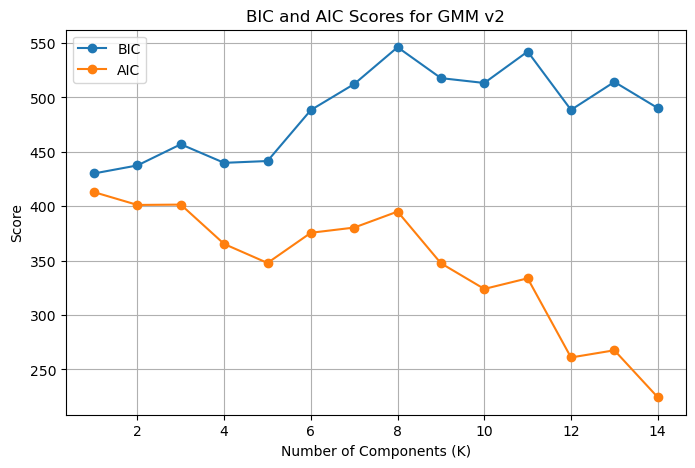

In [81]:
# elbow plot - version 2
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia2, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K v2")
plt.show()

# BIC and AIC score plot - version 2
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), bic_scores2, marker='o', linestyle='-', label='BIC')
plt.plot(range(1, 15), aic_scores2, marker='o', linestyle='-', label='AIC')
plt.xlabel('Number of Components (K)')
plt.ylabel('Score')
plt.legend()
plt.title('BIC and AIC Scores for GMM v2')
plt.grid(True)
plt.show()



*Notes on K and Component Optimization v2*

- the elbow plot is very similar to v1: it has a characteristic shape and shows decreasing improvement after k = 4
- the BIC and AIC curves continue to have have an unexpected shape, but v2 has improved on v1
- because the BIC curve increases for low K values, I will not take this analysis further since it doesn't make intuitive sense that going from 1 to 2 components makes the model fit worse

v3 of this exercise drops Assault and Urban Pop data from the analysis, since their histograms are the most uniformly distributed.

In [82]:
# Select numerical features for clustering - version 3
X3 = df[['Murder', 'Rape']]

# Standardize the data
scaler = StandardScaler()
X3_scaled = scaler.fit_transform(X3)

In [83]:
# elbow method to find optimal K for K-Means - version 3
inertia3 = []
K_range = range(1, 12)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X3_scaled)
    inertia3.append(kmeans.inertia_)

In [84]:
# BIC and AIC to find optimal components for GMM - version 3
bic_scores3 = []
aic_scores3 = []
for n in range(1, 15):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X3_scaled)
    bic_scores3.append(gmm.bic(X3_scaled))
    aic_scores3.append(gmm.aic(X3_scaled))




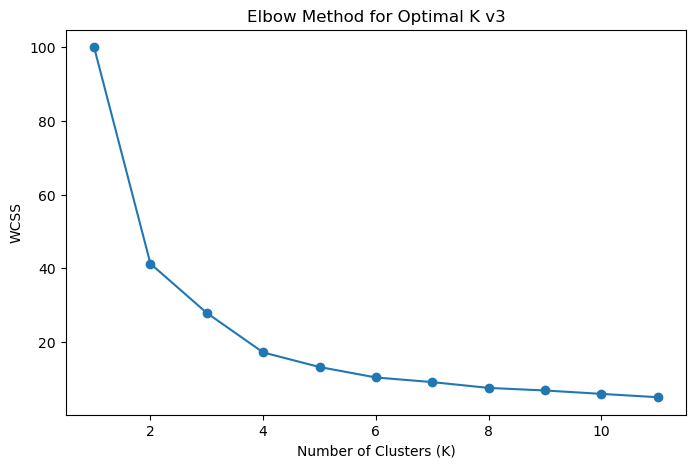

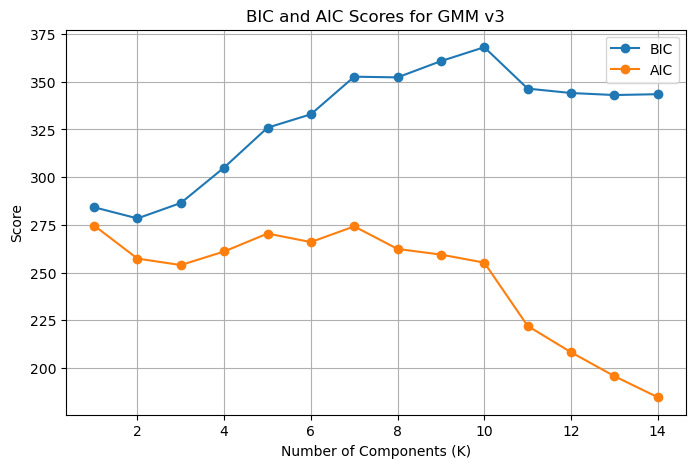

In [86]:
# elbow plot - version 3
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia3, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K v3")
plt.show()

# BIC and AIC score plot - version 3
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), bic_scores3, marker='o', linestyle='-', label='BIC')
plt.plot(range(1, 15), aic_scores3, marker='o', linestyle='-', label='AIC')
plt.xlabel('Number of Components (K)')
plt.ylabel('Score')
plt.legend()
plt.title('BIC and AIC Scores for GMM v3')
plt.grid(True)
plt.show()



In [88]:
# version 1
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels1 = kmeans.fit_predict(X1_scaled)

gmm = GaussianMixture(n_components=10, random_state=42, covariance_type='full')
gmm_labels1 = gmm.fit_predict(X1_scaled)

In [ ]:
# function to draw circles around K-Means clusters
def draw_kmeans_circles(ax, kmeans, X1_scaled, kmeans_labels1):
    for i, center in enumerate(kmeans.cluster_centers_):
        cluster_points = X1_scaled[kmeans_labels1 == i]
        std_dev = np.std(cluster_points, axis=0)
        circle = patches.Circle(center, std_dev[0] * 2, color='red', fill=False, 
                                linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(circle)

# function to draw ellipses for GMM clusters
def draw_gmm_ellipses(ax, gmm, X1_scaled):
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        covariances = gmm.covariances_[i]

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariances)

        # Extract the angle of rotation
        largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
        angle = np.degrees(np.arctan2(largest_eigenvector[1], largest_eigenvector[0]))

        # Width and height of the ellipse (95% confidence interval)
        width = 2 * np.sqrt(eigenvalues[0])
        height = 2 * np.sqrt(eigenvalues[1])

        # Create and add the ellipse
        ellipse = patches.Ellipse(mean, width, height, angle=angle, edgecolor='blue',
                                  facecolor='none', linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(ellipse)

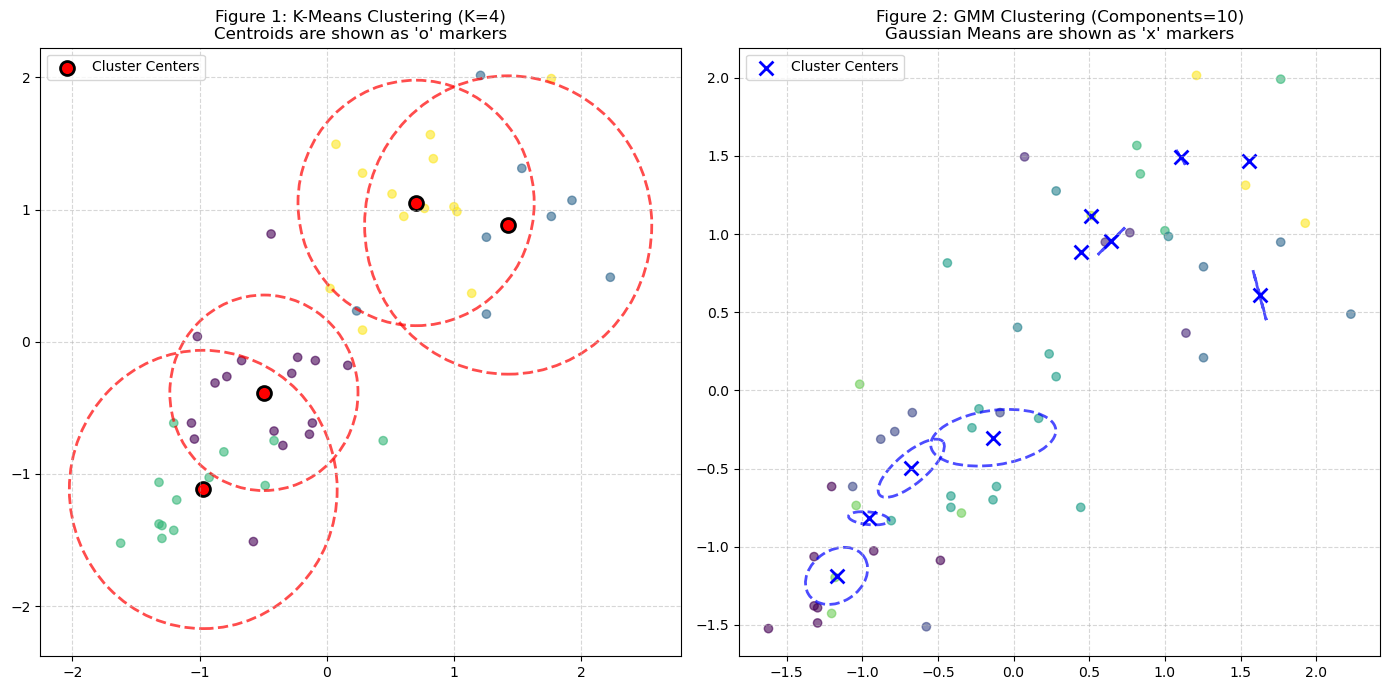

In [ ]:
# figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# K-Means Plot
axes[0].scatter(X1_scaled[:, 0], X1_scaled[:, 1], c=kmeans_labels1, cmap='viridis', alpha=0.6)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=100, c='red', marker='o', edgecolors='black', linewidth=2, label="Cluster Centers")
draw_kmeans_circles(axes[0], kmeans, X1_scaled, kmeans_labels1)
axes[0].set_title("Figure 1: K-Means Clustering (K=4)\nCentroids are shown as 'o' markers")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# GMM Plot
axes[1].scatter(X1_scaled[:, 0], X1_scaled[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                s=100, c='blue', marker='x', linewidth=2, label="Cluster Centers")
draw_gmm_ellipses(axes[1], gmm, X1_scaled)
axes[1].set_title("Figure 2: GMM Clustering (Components=10)\nGaussian Means are shown as 'x' markers")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

In [92]:
# version 3
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels3 = kmeans.fit_predict(X3_scaled)

gmm3 = GaussianMixture(n_components=2, random_state=42, covariance_type='full')
gmm_labels3 = gmm3.fit_predict(X3_scaled)

In [93]:
# version 3

# function to draw circles around K-Means clusters
def draw_kmeans_circles(ax, kmeans, X3_scaled, kmeans_labels3):
    for i, center in enumerate(kmeans.cluster_centers_):
        cluster_points = X3_scaled[kmeans_labels3 == i]
        std_dev = np.std(cluster_points, axis=0)
        circle = patches.Circle(center, std_dev[0] * 2, color='red', fill=False, 
                                linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(circle)

# function to draw ellipses for GMM clusters
def draw_gmm_ellipses(ax, gmm3, X3_scaled):
    for i in range(gmm3.n_components):
        mean = gmm3.means_[i]
        covariances = gmm3.covariances_[i]

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariances)

        # Extract the angle of rotation
        largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
        angle = np.degrees(np.arctan2(largest_eigenvector[1], largest_eigenvector[0]))

        # Width and height of the ellipse (95% confidence interval)
        width = 2 * np.sqrt(eigenvalues[0])
        height = 2 * np.sqrt(eigenvalues[1])

        # Create and add the ellipse
        ellipse = patches.Ellipse(mean, width, height, angle=angle, edgecolor='blue',
                                  facecolor='none', linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(ellipse)

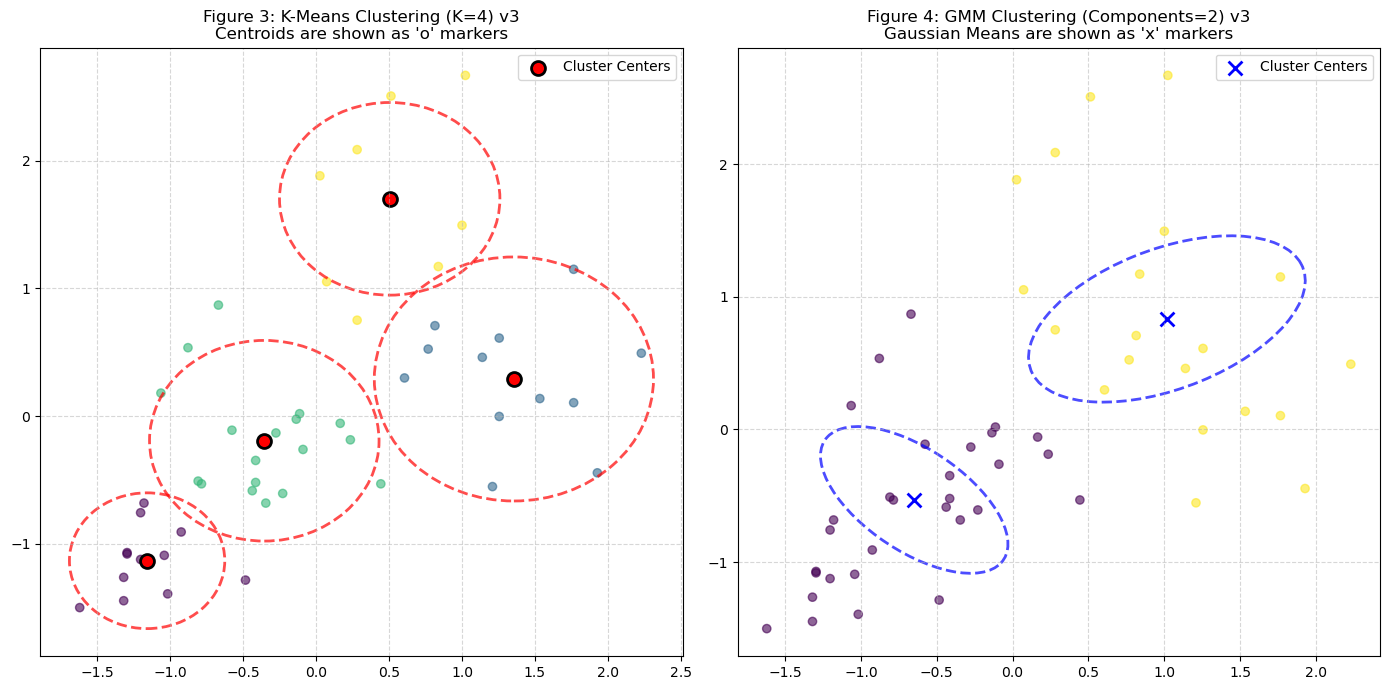

In [94]:
# version 3

# figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# K-Means Plot
axes[0].scatter(X3_scaled[:, 0], X3_scaled[:, 1], c=kmeans_labels3, cmap='viridis', alpha=0.6)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=100, c='red', marker='o', edgecolors='black', linewidth=2, label="Cluster Centers")
draw_kmeans_circles(axes[0], kmeans, X3_scaled, kmeans_labels3)
axes[0].set_title("Figure 3: K-Means Clustering (K=4) v3\nCentroids are shown as 'o' markers")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# GMM Plot
axes[1].scatter(X3_scaled[:, 0], X3_scaled[:, 1], c=gmm_labels3, cmap='viridis', alpha=0.6)
axes[1].scatter(gmm3.means_[:, 0], gmm3.means_[:, 1],
                s=100, c='blue', marker='x', linewidth=2, label="Cluster Centers")
draw_gmm_ellipses(axes[1], gmm3, X1_scaled)
axes[1].set_title("Figure 4: GMM Clustering (Components=2) v3\nGaussian Means are shown as 'x' markers")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

#### Summary of Model Performance and Other Notes



The first fitting of both K-Means and GMM was largely unsuccessful. The K-Means chart (fig 1) shows a significant amount of cluster overlap, and the GMM chart (fig 2) shows clusters that don't clearly identify distinct groups.

In the second fitting of K-Means and GMM, I dropped the Assault data element because its histogram was the most homogeneous of the 4 data elements. This attempt was also not successful: I did not complete the fitting because the BIC/AIC chart continued to have an unusual shape.

The third fitting of K-Means and GMM dropped both Assault and UrbanPop, again because their historgrams were the most homogeneous. This attempt was more successful, particularly for the K-Means model.

- in figure 3, you can see 4 reasonably distinct clusters (although there is small amount of overlap in a few cases). These clusters also encapsulate most of the data, leaving out a small  number of outliers.
- in figure 4, its evident that the GMM model is still not performing as well as I'd like. The two clusters appear to capture some of the patterns in the data, but it also appears that more than half of the data is outside of either cluster.

Because of time constraints, I was not able to pursue these models further, but see the most promise in K-Means for this particular dataset.